In [1]:
# Import relevant libraries for the project
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report

In [12]:
plt.style.use('dark_background')

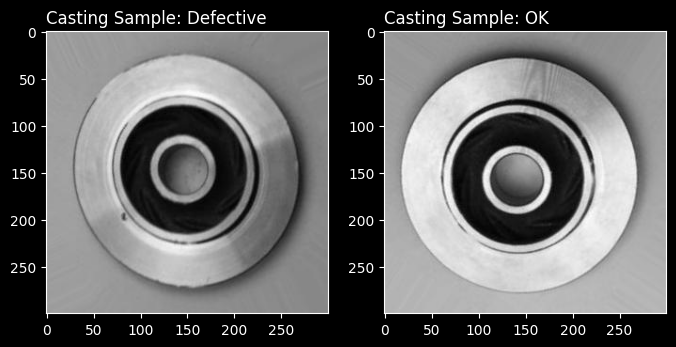

In [13]:
# Specify directory of train data
dir_train = 'C:/Users/sertac/Desktop/roundCNN/casting_data/train/'
dir_train_def = dir_train+'def_front/'  # Class label: Defective
dir_train_ok = dir_train+'ok_front/'    # Class label: OK

# Specify directory of test data
dir_test = 'C:/Users/sertac/Desktop/roundCNN/casting_data/test/'
dir_test_def = dir_test+'def_front/'
dir_test_ok = dir_test+'ok_front/'

# Plot samples of defective and non-defective casting
fig, axes = plt.subplots(1, 2, figsize=(8,4))
sample_def = plt.imread(dir_train_def+os.listdir(dir_train_def)[0])
sample_ok = plt.imread(dir_train_ok+os.listdir(dir_train_ok)[0])
axes[0].imshow(sample_def)
axes[1].imshow(sample_ok)
axes[0].set_title('Casting Sample: Defective', loc='left')
axes[1].set_title('Casting Sample: OK', loc='left')
axes[0].grid(False)
axes[1].grid(False)

plt.show()

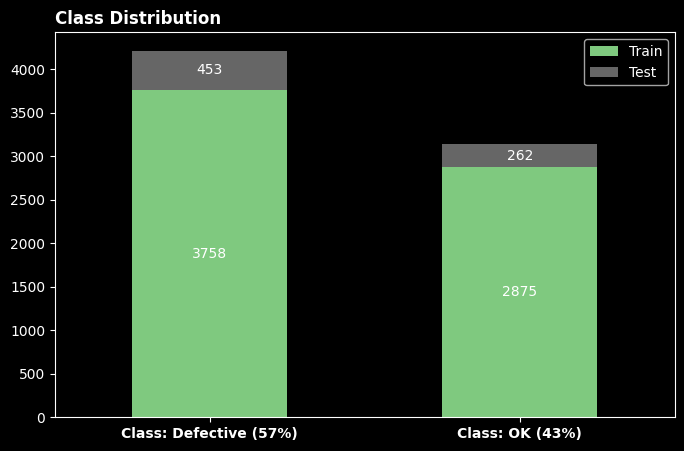

In [14]:
# Create dataframe of class distribution
n_train = [len(os.listdir(dir_train_def)), len(os.listdir(dir_train_ok))]
n_test = [len(os.listdir(dir_test_def)), len(os.listdir(dir_test_ok))]
dist_df = pd.DataFrame(
    data=[n_train, n_test],
    columns=['Defective', 'OK'],
    index=['Train', 'Test'])

# Visualize class distribution
ax = dist_df.T.plot(kind='bar', stacked=True, rot=0, figsize=(8,5), colormap='Accent')
ax.set_title('Class Distribution', loc='left', weight='bold')
for bar in ax.patches:
    ax.text(bar.get_x()+bar.get_width()-0.25, 
            bar.get_y()+bar.get_height()/2,
            int(bar.get_height()),
            ha='center', va='center', color='white')
pct_def = 100*dist_df['Defective'].values.sum()/dist_df.values.sum()
pct_ok = 100-pct_def
ax.set_xticklabels([f'Class: Defective ({pct_def:.0f}%)',
                    f'Class: OK ({pct_ok:.0f}%)'], weight='bold')
plt.show()

In [15]:
# Define instances of ImageDataGenerator
train_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_gen = ImageDataGenerator(rescale=1./255)

# Specify parameters/arguments for data generation
img_size, batch_size, rand_seed = (300, 300), 64, 0
arg_train = {'target_size': img_size,
             'color_mode': 'grayscale',
             'classes': {'ok_front': 0,
                         'def_front': 1},
             'class_mode': 'binary',
             'batch_size': batch_size,
             'seed': rand_seed}
arg_test = {'target_size': img_size,
            'color_mode': 'grayscale',
            'classes': {'ok_front': 0,
                        'def_front': 1},
            'class_mode': 'binary',
            'batch_size': batch_size,
            'seed': rand_seed,
            'shuffle': False}

# Generate data by iterating through directories
train_set = train_gen.flow_from_directory(
    directory=dir_train, subset='training', **arg_train)
valid_set = train_gen.flow_from_directory(
    directory=dir_train, subset='validation', **arg_train)
test_set = test_gen.flow_from_directory(
    directory=dir_test, **arg_test)

Found 5307 images belonging to 2 classes.
Found 1326 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


In [16]:
# Define CNN model architecture
cnn_model = Sequential([ 
    # First block
    Conv2D(32, 3, activation='relu', padding='same', strides=2,input_shape=img_size+(1,)),
    MaxPooling2D(pool_size=2, strides=2),
    # Second block
    Conv2D(64, 3, activation='relu', padding='same', strides=2),
    MaxPooling2D(pool_size=2, strides=2),
    # Flatenning
    Flatten(),
    # Fully connected layers
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')        # Only 1 output
])

# Compile model
cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),  # Default lr
    loss='binary_crossentropy',
    metrics=['accuracy'])

# Display summary of model architecture
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 38, 38, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 19, 19, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 23104)             0         
                                                                 
 dense (Dense)               (None, 128)               2

In [17]:
%%time

# Fit model using train set and validation set
n_epochs = 20
cnn_model.fit(
    train_set,
    validation_data=valid_set,
    epochs=n_epochs,
    verbose=1)

Epoch 1/20
83/83 [==============================] - 54s 557ms/step - loss: 0.6704 - accuracy: 0.6111 - val_loss: 0.5367 - val_accuracy: 0.7225
Epoch 2/20
83/83 [==============================] - 9s 113ms/step - loss: 0.4549 - accuracy: 0.7820 - val_loss: 0.5316 - val_accuracy: 0.7021
Epoch 3/20
83/83 [==============================] - 9s 110ms/step - loss: 0.3919 - accuracy: 0.8170 - val_loss: 0.2963 - val_accuracy: 0.8831
Epoch 4/20
83/83 [==============================] - 9s 110ms/step - loss: 0.2418 - accuracy: 0.9090 - val_loss: 0.1907 - val_accuracy: 0.9329
Epoch 5/20
83/83 [==============================] - 9s 111ms/step - loss: 0.1756 - accuracy: 0.9331 - val_loss: 0.1512 - val_accuracy: 0.9532
Epoch 6/20
83/83 [==============================] - 9s 110ms/step - loss: 0.1275 - accuracy: 0.9568 - val_loss: 0.1698 - val_accuracy: 0.9261
Epoch 7/20
83/83 [==============================] - 9s 112ms/step - loss: 0.1162 - accuracy: 0.9568 - val_loss: 0.1112 - val_accuracy: 0.9668
Epoch

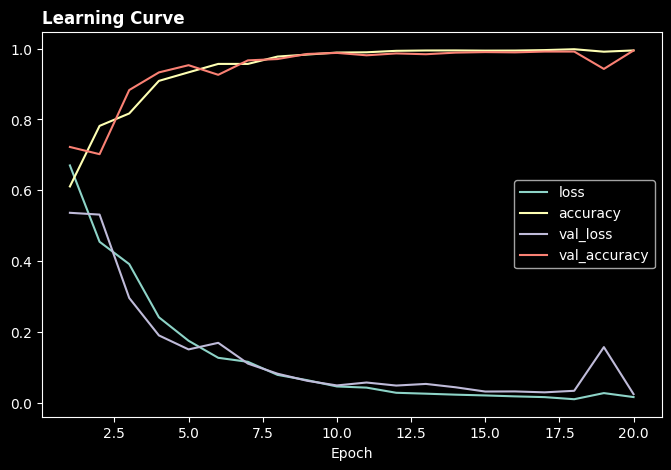

In [18]:
# Plot learning curve from model history
histo_dict = cnn_model.history.history
histo_df = pd.DataFrame(histo_dict, index=range(1,n_epochs+1))
fig, ax = plt.subplots(figsize=(8,5))
for m in histo_df.columns:
    ax.plot(histo_df.index, m, data=histo_df)
ax.set_xlabel('Epoch')
ax.set_title('Learning Curve', loc='left', weight='bold')
ax.legend()
plt.show()

In [27]:
# Make predictions on images in the test set
best_model = cnn_model
y_pred_prob = best_model.predict(test_set, verbose=1)
y_pred = (y_pred_prob >= 0.5).reshape(-1,)
y_true = test_set.classes[test_set.index_array]

12/12 [==============================] - 2s 121ms/step


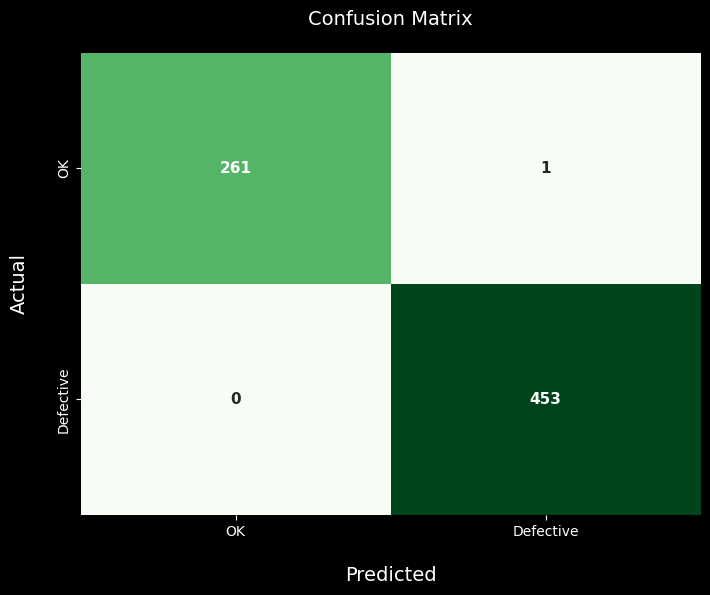

In [28]:
# Visualize the confusion matrix
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.heatmap(confusion_matrix(y_true,y_pred), annot=True,
                 annot_kws={'size':11, 'weight':'bold'},
                 fmt='d', cbar=False, cmap='Greens')
ax.set_xlabel("Predicted", fontsize=14, labelpad=20)
ax.set_ylabel("Actual", fontsize=14, labelpad=20)
ax.set_xticklabels(['OK', 'Defective'])
ax.set_yticklabels(['OK', 'Defective'], va='center')

ax.set_title("Confusion Matrix", fontsize=14, pad=20)
plt.show()

In [29]:
print(classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

           0     1.0000    0.9962    0.9981       262
           1     0.9978    1.0000    0.9989       453

    accuracy                         0.9986       715
   macro avg     0.9989    0.9981    0.9985       715
weighted avg     0.9986    0.9986    0.9986       715



In [32]:
cnn_model.save('model.h5')

In [36]:

# importing numpy
import numpy as np
 
array = np.random.rand(2, 2, 2, 2)
print(array, end="\n\n\n")
print(array[..., 0])


[[[7.86127449e-01 7.46417959e-01]
  [4.70596630e-04 9.90032754e-01]]

 [[3.60707347e-01 4.66426176e-01]
  [7.18675887e-01 9.48224530e-01]]]
